# __COSAN SURFACE DENSITY__
This notebook computes a simple grid around a void cosan molecule and evaluates the stabilization energy of adding an ion to a any point in a 2Å surface from the cluster. 

This measures the understanding of electronic density of the B/C regions of each of the MLIP models. 

In [4]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase.visualize import view
from ase.build import molecule
from ase.io import write, read
from ase.io import Trajectory, trajectory
from ase import build
from ase.data.pubchem import pubchem_atoms_search

import ase.units as units
from ase import Atoms
from ase.calculators.tip3p import TIP3P, angleHOH, rOH
from ase.constraints import FixBondLengths
from ase.io.trajectory import Trajectory
from ase.io.trajectory import TrajectoryReader
from ase.md import Langevin
from ase.md.nptberendsen import NPTBerendsen
from ase.optimize import BFGS
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.calculators.checkpoint import Checkpoint
import pickle

from mpl_toolkits.mplot3d import Axes3D

cmap = 'seismic'

In [2]:
# define the model
# MACE
from mace.calculators import mace_mp

CALC_ASE = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float32", 
    device='cpu',
    )

CALC_NAME = 'MACE'

/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indice

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

In [8]:
# UMA
from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit

# define the UMA ASE calculator
uma_predictor = load_predict_unit(
    path='/Users/sergiortizropero/TFG_phys/NNPs_TFG/models/ase_uma/uma-s-1p1.pt', 
    device='cpu',                   
    inference_settings='default',   
)
CALC_ASE = FAIRChemCalculator(
    uma_predictor,
    task_name='omol',               
)

CALC_NAME = 'UMA'

In [6]:
# ORB-v2
from orb_models.forcefield.pretrained import orb_v2
from orb_models.forcefield.calculator import ORBCalculator

orbff_v2 = orb_v2(device='cpu')
CALC_ASE = ORBCalculator(orbff_v2, device='cpu')

CALC_NAME = 'ORB-v2'

/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/orb_models/utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")


In [10]:
# ORB-v3
from orb_models.forcefield.pretrained import orb_v3_conservative_inf_omat
from orb_models.forcefield.calculator import ORBCalculator

orbff_v3 = orb_v3_conservative_inf_omat(device='cpu')
CALC_ASE = ORBCalculator(orbff_v3, device='cpu')

CALC_NAME = 'ORB'

/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/orb_models/utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")


In [13]:
# define functions
def obtain_cosan():
    

    sim_path = os.path.join('../simulations/', f'cosan_surface')
    if not os.path.exists(sim_path):
        os.makedirs(sim_path)

    print('Fetching void COSAN system')
    atoms = read(os.path.join('./structures/cosan/cosan_void.xyz'))
    atoms.info = {
        'spin': 1,
        'charge': -1,
    }

    atoms.positions = atoms.get_positions() - atoms.get_positions()[22]
    return atoms, sim_path


def preprocess_grid(atoms, sim_path, isodistance=3, resolution=0.1):

    grid_dir = os.path.join(sim_path, f'surface_points_{isodistance}A.txt')
    grid_dims = [9, 9, 15]

    # check if grid has already been preprocessed
    if not os.path.exists(grid_dir):

        # define grid
        x_coords = np.arange(-grid_dims[0]/2., grid_dims[0]/2.+resolution, resolution)
        y_cords = np.arange(-grid_dims[1]/2., grid_dims[1]/2.+resolution, resolution)
        z_coords = np.arange(-grid_dims[2]/2., grid_dims[2]/2.+resolution, resolution)
    
        surface_points = []
        cosan_atoms = atoms.get_positions()

        with open(grid_dir, 'w') as f:


             # obtain the subset of points at a 1.9-2.1 Å distance
            for i in x_coords:
                for j in y_cords:
                    for k in z_coords:

                        coord = [i, j, k]
                        distances = []
                        for l in cosan_atoms:
                            dist = np.sqrt((coord[0] - l[0])**2 + (coord[1] - l[1])**2 + (coord[2] - l[2])**2)
                            distances.append(dist)

                        # obtain maixmum distance
                        max_dist = np.min(distances)
                        
                        if max_dist > (isodistance-0.005) and max_dist < (isodistance+0.005):
                            print(max_dist)
                            surface_points.append(coord)

                            #  save to file
                            f.write(f'{coord[0]}\t{coord[1]}\t{coord[2]}\n')
    
    else:
        print(f'grid was already preprocessed @ {grid_dir}')
        print('skipping grid preprocessing')
        raw_data = np.loadtxt(grid_dir)

        surface_points = []
        for i in range(len(raw_data)):
            surface_points.append(raw_data[i].tolist())

    # return the list of points
    return np.array(surface_points)



def evaluate_energies(atoms, surface_points, CALC_ASE, sim_path, isodistance=3):

    # save to file
    energy_path = os.path.join(sim_path, f'energy_values_{CALC_NAME}_{isodistance}A.txt')

    # define system components
    cosan = atoms.copy()
    cosan.calc = CALC_ASE
    cosan.info = {'spin': 1, 'charge': -1}

    # TODO this approach will explode with UMA, it is a monoatomic system
    sodium = Atoms('Na', positions=[[0.,0.,0.]])
    sodium.calc = CALC_ASE
    sodium.info = {'spin': 1, 'charge': +1}

    if not os.path.exists(energy_path):
        
        energies = []
        relative_energies = []
        
        # perform the calculation of COSAN and Sodium ion separately
        cosan_energy = cosan.get_potential_energy()
        if CALC_NAME == 'UMA':
            sodium_energy = 0.0
        else:
            sodium_energy = sodium.get_potential_energy()
        
        with open(energy_path, 'w') as f:
            
            # perform single point calculations for each point (new atoms object every time)
            k = 0
            for point in surface_points:
                
                #if k > 300:
                #    break

                print(f'computing energy for point {point}')

            
                # generate the atomic arrangement
                atom_config = cosan + Atoms('Na', positions=[point])
                atom_config.info = {'spin': 1, 'charge': -1}

                #if k%25 == 0:
                #    view(atom_config, viewer='ase')
                
                # compute energy
                atom_config.calc = CALC_ASE
                total_energy = atom_config.get_potential_energy()

                # compute the association energy at each position
                energy = total_energy - cosan_energy - sodium_energy
                energies.append(energy)

                # TODO correct the energies relative to 'zero' (what is zero tho?)     
        
                f.write(f'{energy}\n')
                k += 1

    else:
        print(f'energies were found @ {energy_path}')
        print('retreiving energies from file')
        raw_data = np.loadtxt(energy_path)
        energies = []
        for i in range(len(raw_data)):
            energies.append(raw_data[i].tolist())

    return energies


def plot_surface():


    # plot the association energy surface (plt 3D) at two angles, front and rear


    pass


In [14]:
isodistance = 2
atoms, sim_path = obtain_cosan()
grid_points = preprocess_grid(atoms, sim_path, isodistance)
energies = evaluate_energies(atoms, grid_points, CALC_ASE, sim_path, isodistance)

Fetching void COSAN system
grid was already preprocessed @ ../simulations/cosan_surface/surface_points_2A.txt
skipping grid preprocessing
computing energy for point [-4.4 -0.5 -1.4]
computing energy for point [-4.4 -0.5 -0.9]
computing energy for point [-4.4 -0.2 -0.6]
computing energy for point [-4.4 -0.1 -1.7]
computing energy for point [-4.4  0.1 -1.7]
computing energy for point [-4.4  0.2 -1.7]
computing energy for point [-4.4  0.4 -1.6]
computing energy for point [-4.4  0.4 -0.7]
computing energy for point [-4.4  0.5 -1.5]
computing energy for point [-4.4  0.5 -0.8]
computing energy for point [-4.4  0.6 -1.3]
computing energy for point [-4.4  0.6 -1.2]
computing energy for point [-4.4  0.6 -1.1]
computing energy for point [-4.4  0.6 -1. ]
computing energy for point [-4.3 -0.8 -1.3]
computing energy for point [-4.3 -0.8 -1. ]
computing energy for point [-4.3 -0.7 -0.7]
computing energy for point [-4.3 -0.6 -1.7]
computing energy for point [-4.3 -0.5 -1.8]
computing energy for point

front side of the COSAN (Carbon region)
back side of the COSAN (Boron region)


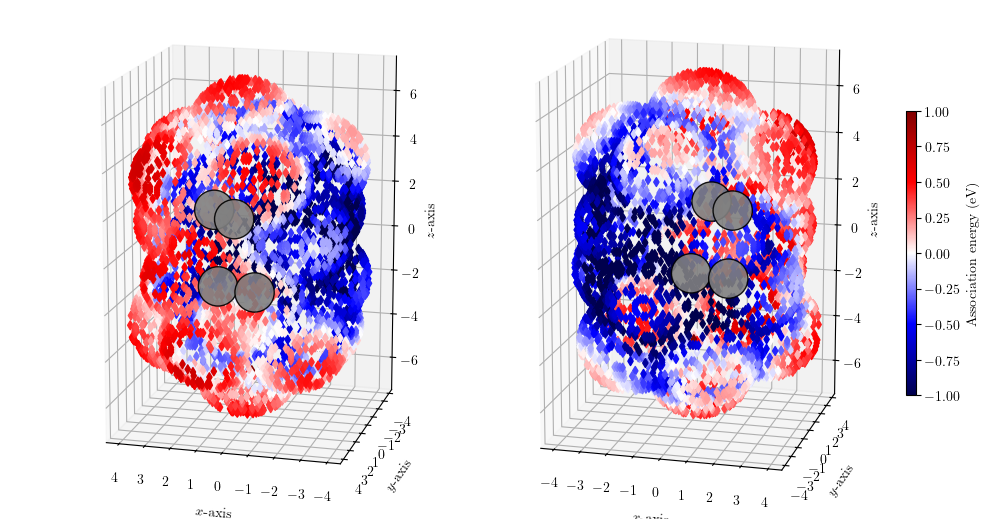

In [26]:

if CALC_NAME == 'MACE':
    cbar_lims = [-0.8, -2.1]
if CALC_NAME == 'ORB':
    cbar_lims = [0.0, -1.1]
if CALC_NAME == 'UMA':
    cbar_lims = [1, -1]
#cbar_lims = None

x = grid_points[:, 0]
y = grid_points[:, 1]
z = grid_points[:, 2]  
colors = [k + 4415 for k in energies] 


print('front side of the COSAN (Carbon region)')
fig = plt.figure(figsize=(10, 6))




#
#   FIRST PLOT
#
ax = fig.add_subplot(121, projection='3d', computed_zorder=False)
ax.set_box_aspect((1, 1, 1.5))

if cbar_lims is not None:
    surf = ax.scatter3D(x, y, z, c=colors, cmap=cmap, marker='d', vmin=cbar_lims[1], vmax=cbar_lims[0], alpha=1, zorder=0)
else: 
    surf = ax.scatter3D(x, y, z, c=colors, cmap=cmap, marker='d', alpha=1, zorder=0)
#fig.colorbar(surf, ax=ax, fraction=0.02, pad=-0.05, label=r'$\textnormal{Association energy (eV)}$', aspect=30)

all_pos = atoms.get_positions()
C_atoms_pos = np.array([all_pos[0], all_pos[6], all_pos[11], all_pos[17]])
x_C = C_atoms_pos[:, 0]
y_C = C_atoms_pos[:, 1]
z_C = C_atoms_pos[:, 2] 
ax.scatter3D(x_C, y_C, z_C, c='grey', alpha=0.9, zorder=5, s=800, edgecolors='black')

ax.set_xlabel(r'$\textnormal{$x$-axis}$')
ax.set_xlim3d(-4.5, 4.5)
ax.set_ylabel(r'$\textnormal{$y$-axis}$')
ax.set_ylim3d(-4.5, 4.5)
ax.set_zlabel(r'$\textnormal{$z$-axis}$')
ax.set_zlim3d(-7.5, 7.5)
ax.view_init(azim=105, elev=15, roll=0)



#
#   SECOND PLOT
#
print('back side of the COSAN (Boron region)')
ax = fig.add_subplot(122, projection='3d', computed_zorder=False)
ax.set_box_aspect((1, 1, 1.5))


if cbar_lims is not None:
    surf = ax.scatter3D(x, y, z, c=colors, cmap=cmap, marker='d', vmin=cbar_lims[1], vmax=cbar_lims[0], alpha=1, zorder=0)
else: 
    surf = ax.scatter3D(x, y, z, c=colors, cmap=cmap, marker='d', alpha=1, zorder=0)
fig.colorbar(surf, ax=ax, fraction=0.02, pad=-0.05, label=r'$\textnormal{Association energy (eV)}$', aspect=30)

all_pos = atoms.get_positions()
C_atoms_pos = np.array([all_pos[0], all_pos[6], all_pos[11], all_pos[17]])
x_C = C_atoms_pos[:, 0]
y_C = C_atoms_pos[:, 1]
z_C = C_atoms_pos[:, 2]
ax.scatter3D(x_C, y_C, z_C, c='grey', alpha=0.9, zorder=5, s=800, edgecolors='black')

ax.set_xlabel(r'$\textnormal{$x$-axis}$')
ax.set_xlim3d(-4.5, 4.5)
ax.set_ylabel(r'$\textnormal{$y$-axis}$')
ax.set_ylim3d(-4.5, 4.5)
ax.set_zlabel(r'$\textnormal{$z$-axis}$')
ax.set_zlim3d(-7.5, 7.5)
ax.view_init(azim=105+180, elev=15, roll=0)

plt.subplots_adjust(wspace=-0.42)
plt.tight_layout()
plt.savefig(os.path.join(sim_path, f'cosan_density_{CALC_NAME}_{isodistance}.png'), dpi=400)
plt.show()

Done!